In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install torch
!pip install text_hammer
#!pip install transformers datasets
!pip install datasets

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import text_hammer as th
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
nlp = spacy.load("en_core_web_sm")
from transformers import pipeline
from sklearn.metrics import f1_score
from transformers import XLNetTokenizer, XLNetLMHeadModel
from transformers import BertTokenizer, BertLMHeadModel
import random
import numpy as np

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
squad = load_dataset("squad", split="train[:1000]")
squad = squad.train_test_split(test_size=0.2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
tokenizer1 = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer2 = AutoTokenizer.from_pretrained("gpt2")
#tokenizer3 = AutoTokenizer.from_pretrained("gpt1")
if tokenizer2.pad_token is None:
    tokenizer2.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def preprocess_function_xlnet(examples):
    questions = [q.strip() for q in examples["question"]]
    #print(questions)
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
def preprocess_function_bert(examples):
    questions = [q.strip() for q in examples["question"]]
    #print(questions)
    inputs = tokenizer1(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
def preprocess_function_gpt(examples):
    questions = [q.strip() for q in examples["question"]]
    #print(questions)
    inputs = tokenizer1(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
tokenized_squad_xlnet = squad.map(preprocess_function_xlnet, batched=True, remove_columns=squad["train"].column_names)
tokenized_squad_bert = squad.map(preprocess_function_bert, batched=True, remove_columns=squad["train"].column_names)
tokenized_squad_gpt = squad.map(preprocess_function_gpt, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
data_collator = DefaultDataCollator()

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("xlnet-base-cased")
model1 = AutoModelForQuestionAnswering.from_pretrained("bert-base-uncased")
model2 = AutoModelForQuestionAnswering.from_pretrained("gpt2")

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForQuestionAnswering were not initialized from the model checkpoint at gpt2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="squad_qa_model_xlnet",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

model=model
args=training_args
train_dataset=tokenized_squad_xlnet["train"]
eval_dataset=tokenized_squad_xlnet["test"]
tokenizer=tokenizer
data_collator=data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad_xlnet["train"],
    eval_dataset=tokenized_squad_xlnet["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
trainer.save_model("squad_qa_model_xlnet")

Epoch,Training Loss,Validation Loss
1,No log,2.786293
2,No log,1.531570
3,No log,1.330041
4,No log,1.351167
5,No log,1.342619


In [ ]:
training_args1 = TrainingArguments(
    output_dir="squad_qa_model_bert",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer1 = Trainer(
    model=model1,
    args=training_args1,
    train_dataset=tokenized_squad_bert["train"],
    eval_dataset=tokenized_squad_bert["test"],
    tokenizer=tokenizer1,
    data_collator=data_collator,
)

trainer1.train()
trainer1.save_model("squad_qa_model_bert")

Epoch,Training Loss,Validation Loss
1,No log,3.866453
2,No log,2.588541
3,No log,2.223104
4,No log,2.129427
5,No log,2.139388


In [ ]:
training_args2 = TrainingArguments(
    output_dir="squad_qa_model_gpt",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=tokenized_squad_gpt["train"],
    eval_dataset=tokenized_squad_gpt["test"],
    tokenizer=tokenizer1,
    data_collator=data_collator,
)

trainer2.train()
trainer2.save_model("squad_qa_model_gpt")

Epoch,Training Loss,Validation Loss
1,No log,5.077470
2,No log,4.971486
3,No log,4.847249
4,No log,4.771833
5,No log,4.754010


In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
def cleaning(s):
  s=s.lower()
  s=th.cont_exp(s)
  s=th.remove_emails(s)
  s=th.remove_html_tags(s)
  s=th.remove_urls(s)
  #s=th.remove_stopwords(s)
  s=th.remove_special_chars(s)
  #s=th.remove_accented_chars(s)
  #s=th.make_base(s)
  lemmatizer = WordNetLemmatizer()
  s=lemmatizer.lemmatize(s,get_wordnet_pos(s))
  return s

**Elongated Text Generation**

In [ ]:
!pip install datasets
from datasets import load_dataset
squad = load_dataset("squad", split="train[:10000]")
print(squad[8000])
print(squad[1000])

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

{'id': '56d9cadedc89441400fdb82c', 'title': 'Dog', 'context': 'There are a vast range of commodity forms available to transform a pet dog into an ideal companion. The list of goods, services and places available is enormous: from dog perfumes, couture, furniture and housing, to dog groomers, therapists, trainers and caretakers, dog cafes, spas, parks and beaches, and dog hotels, airlines and cemeteries. While dog training as an organized activity can be traced back to the 18th century, in the last decades of the 20th century it became a high profile issue as many normal dog behaviors such as barking, jumping up, digging, rolling in dung, fighting, and urine marking (which dogs do to establish territory through scent), became increasingly incompatible with the new role of a pet dog. Dog training books, classes and television programs proliferated as the process of commodifying the pet dog continued.', 'question': 'How far back can dog training be found?', 'answers': {'text': ['18th cent

In [ ]:
print(squad[1000])
print(squad[2000])

{'id': '56bfe7eaa10cfb1400551389', 'title': 'Beyoncé', 'context': 'After Hurricane Katrina in 2005, Beyoncé and Rowland founded the Survivor Foundation to provide transitional housing for victims in the Houston area, to which Beyoncé contributed an initial $250,000. The foundation has since expanded to work with other charities in the city, and also provided relief following Hurricane Ike three years later.', 'question': 'How much did Beyonce initially contribute to the foundation?', 'answers': {'text': ['$250,000'], 'answer_start': [190]}}
{'id': '56d3823659d6e414001465b7', 'title': 'Frédéric_Chopin', 'context': 'With his health further deteriorating, Chopin desired to have a family member with him. In June 1849 his sister Ludwika came to Paris with her husband and daughter, and in September, supported by a loan from Jane Stirling, he took an apartment at Place Vendôme 12. After 15 October, when his condition took a marked turn for the worse, only a handful of his closest friends rema

In [ ]:
def summarize_with_keywords(text, keyword):
  filtered_sentences = [sentence for sentence in text.split(".")]
  #print(filtered_sentences)
  for i in filtered_sentences:
    #print(i)
    if keyword in i:
      #print(i)
      return i

In [ ]:
!pip install -U transformers
!pip install torch
from transformers import XLNetTokenizer, XLNetLMHeadModel
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')
from transformers import pipeline
import torch
import numpy as np
import random

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def choose_from_top(probs, k=2, sample_size=1):
    ind = np.argpartition(probs, -k)[-k:]
    top_prob = probs[ind]
    # print(tokenizer.decode(ind))
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(k, sample_size, p = top_prob, replace=False)
    token_ids = ind[choice]
    return token_ids

In [ ]:
def candidates_gen(PADDING_TEXT,sent_tokens, candidate=([], 1, []), d='left', n_candidates=5, topk=20, temperature=5):
  padding_tokens = tokenizer.encode(PADDING_TEXT, add_special_tokens=False)
  mask_tokens = tokenizer.encode('<mask>', add_special_tokens=False)

  model.eval()
  if torch.cuda.is_available(): model.to('cuda') #if we have a GPU
  branch_candidates = []
  cand_tokens = candidate[0]

  if d == 'right':
    #target_id = len(input)
    input = sent_tokens + cand_tokens + mask_tokens

    target_id = -1
    input_ids = torch.tensor(padding_tokens + input).unsqueeze(0)
    #input_ids = torch.tensor([tokenizer.cls_token_id] + padding_tokens + input + [tokenizer.sep_token_id]).unsqueeze(0)
    perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
    perm_mask[0, :, target_id] = 1.0  # Previous tokens don't see last token
  else:
    input = mask_tokens + cand_tokens + sent_tokens

    target_id = -len(input)
    input_ids = torch.tensor(padding_tokens + input).unsqueeze(0)

    perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
    perm_mask[0, :, [target_id - i for i in range(100)]] = 1.0  # Mask additional previos tokens to improve left-side generation

  # We will predict masked tokens
  target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float)
  target_mapping[0, 0, target_id] = 1.0  # Our right  prediction

  if torch.cuda.is_available():
    input_ids_tensor = input_ids.to("cuda")
    target_mapping_tensor = target_mapping.to("cuda")
    perm_mask_tensor = perm_mask.to("cuda")
  else:
    input_ids_tensor = input_ids
    target_mapping_tensor = target_mapping
    perm_mask_tensor = perm_mask

  with torch.no_grad():
    outputs = model(input_ids_tensor, perm_mask=perm_mask_tensor, target_mapping=target_mapping_tensor)
    #outputs = model(input_ids_tensor)

  probs = torch.nn.functional.softmax(outputs[0][0][0]/temperature, dim = 0)
  selected_indexes = choose_from_top(probs.to('cpu').numpy(), k=topk, sample_size=n_candidates)
  selected_probs = probs[selected_indexes]

  for i,item  in enumerate(selected_indexes):
      the_index = item.item()
      if d == "right":
        new_sent = cand_tokens + [the_index]
      elif d == "left":
        new_sent = [the_index] + cand_tokens

      prob = selected_probs[i].item()
      # add word combinations to branch_candidates in format [sentence, cumulative probability, all probs]
      branch_candidates.append((new_sent, candidate[1] * prob, candidate[2] + [prob]))

  return branch_candidates

In [ ]:
def beam_gen(PADDING_TEXT,sent_tokens, candidates, depth=5, d='right', sample_size=2, topk=10, temperature=5):
  beams = candidates[:]
  new_candidates = candidates[:]
  while depth > 0:
    new_candidates = []
    for candidate in candidates:
      for new_candidate in candidates_gen(PADDING_TEXT,sent_tokens, candidate, d, sample_size, topk, temperature):
        beams.append(new_candidate)
        new_candidates.append(new_candidate)
    #print("Number of beams:", len(new_candidates))
    candidates = new_candidates[:]
    depth -= 1
  # sort candidate beams by a sum of logaryphms of probability of each word in a beam. Which is equivalet to product of probabilities
  sorted_beams = sorted(new_candidates, key=lambda tup: np.sum(np.log10(tup[2])), reverse=True)
  return beams, sorted_beams

In [ ]:
def bi_generator(PADDING_TEXT,sent, direction, first_sample_size, sample_size, n_tokens, topk, iterations, temperature):
  sent_tokens = tokenizer.encode(sent, add_special_tokens=False)

  for i in range(iterations):
    if (i % 2 == 0 and direction == 'both') or direction == 'left':
      #print('>> left side generation')
      candidates = candidates_gen(PADDING_TEXT,sent_tokens=sent_tokens, d='left', n_candidates=first_sample_size,  topk=topk, temperature=temperature)
      beams, sorted_beams = beam_gen(PADDING_TEXT,sent_tokens, candidates, n_tokens-1, 'left', sample_size, topk, temperature=temperature)
      topn = len(sorted_beams)//5 if len(sorted_beams) > 4 else len(sorted_beams)
      selected_candidate = random.choice(sorted_beams[:topn])
      sent_tokens = selected_candidate[0] + sent_tokens
      #print(tokenizer.decode(sent_tokens))
    if (i % 2 != 0 and direction == 'both') or direction == 'right':
      #print('>> right side generation')
      candidates = candidates_gen(PADDING_TEXT,sent_tokens=sent_tokens, d='right', n_candidates=first_sample_size, topk=topk, temperature=temperature)
      beams, sorted_beams = beam_gen(PADDING_TEXT,sent_tokens, candidates, n_tokens-1, 'right', sample_size, topk, temperature=temperature)
      topn = len(sorted_beams)//5 if len(sorted_beams) > 4 else len(sorted_beams)
      selected_candidate = random.choice(sorted_beams[:topn])
      sent_tokens = sent_tokens + selected_candidate[0]
      #print(tokenizer.decode(sent_tokens))

  return tokenizer.decode(sent_tokens)

In [ ]:
def elongated(context,summary):
  sent = summary
  #l=sent.split(" ")
  first_sample_size = 4
  sample_size = 2
  n_tokens = 5
  topk = 20
  iterations = 15
  temperature = 2
  direction = "right"
  stri=bi_generator(context,sent, direction, first_sample_size, sample_size, n_tokens, topk, iterations, temperature);
  #t = -1
  #for x in range(len(stri) - 2, 0, -1):
    #if ((stri[x] == '.' and (stri[x + 1] >= 'A' and stri[x + 1] <= 'Z')or(stri[x + 1] >= 'a' and stri[x + 1] <= 'z')) or (stri[x]=='.' and stri[x + 1] == '')):
          #t = x
          #break
  #if(t>=0):
    #stri=stri[0:t+1]
  q=stri.split(".")
  print(q[0:len(q)])
  stri=(".").join(q[0:len(q)-1])

  return stri

In [ ]:
def training(question,context):
  #context=cleaning(context)
  question_answerer = pipeline("question-answering", model="/content/drive/MyDrive/Capstone/squad_qa_model")
  #question_answerer = pipeline("question-answering", model="squad_qa_model_xlnet")
  t=question_answerer(question=question, context=context)
  #question_answerer1 = pipeline("question-answering", model="squad_qa_model_bert")
  #t1=question_answerer1(question=question, context=context)
  #question_answerer2 = pipeline("question-answering", model="squad_qa_model_gpt")
  #t2=question_answerer2(question=question, context=context)
  keyword = t.get('answer')
  l=keyword.split(".")
  summary = summarize_with_keywords(context, l[0])
  print(t)
  print(summary)
  #print('xlnet',t)
  #print('bert',t1)
  #print('gpt2',t2)
  #print(summary)
  i=elongated(context,summary)
  return i

In [ ]:
question = "Who has the power to destroy bad karma?"
question1 = "Where do I live ?"
context = """In Theravada Buddhism there can be no divine salvation or forgiveness for one's karma, since it is a purely impersonal process that is a part of the makeup of the universe.[citation needed] In Mahayana Buddhism, the texts of certain Mahayana sutras (such as the Lotus Sutra, the Aṅgulimālīya Sūtra and the Mahāyāna Mahāparinirvāṇa Sūtra) claim that the recitation or merely the hearing of their texts can expunge great swathes of negative karma. Some forms of Buddhism (for example, Vajrayana) regard the recitation of mantras as a means for cutting off of previous negative karma. The Japanese Pure Land teacher Genshin taught that Amitābha has the power to destroy the karma that would otherwise bind one in saṃsāra."""
#context=cleaning(context)
#question=cleaning(question)
context1="My name is Tanmay Mehrotra.My age is 22.I live in Uttar Pradesh.My address is 98 Baghambari Housing Scheme Allapur Prayagraj."
training(question1,context1)

{'score': 0.9644154906272888, 'start': 50, 'end': 66, 'answer': 'Uttar Pradesh.My'}
I live in Uttar Pradesh
['I live in Uttar Pradesh', ' Your name if you remember you are Tanmay Mahrotra', 'The reason you dont remember is : : : : : : : : "<unk><unk>-', '', '<unk><unk>—<unk>', '<eop><eod>"<unk>!<unk>!<unk>!<unk><unk><unk>!']


'I live in Uttar Pradesh. Your name if you remember you are Tanmay Mahrotra.The reason you dont remember is : : : : : : : : "<unk><unk>-..<unk><unk>—<unk>'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from flask import Flask, render_template, request
from google.colab import output
output.serve_kernel_port_as_window(8084)
app = Flask(__name__)
app.static_folder = 'static'
@app.route("/")
def home():
    return render_template("index.html")
    #return "hello"
@app.route("/get")
def response():
    context = request.args.get('context')
    question = request.args.get('question')
    t=training(question,context)
    print(t)
    return t
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8084)

<IPython.core.display.Javascript object>

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8084
 * Running on http://172.28.0.12:8084
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [09/May/2024 05:24:30] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/May/2024 05:24:31] "GET /static/styles/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/May/2024 05:24:32] "GET /static/img/logo.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/May/2024 05:24:33] "GET /static/img/logo.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/May/2024 05:24:44] "GET /static/img/person.png HTTP/1.1" 200 -


{'score': 0.9644154906272888, 'start': 50, 'end': 66, 'answer': 'Uttar Pradesh.My'}
I live in Uttar Pradesh


INFO:werkzeug:127.0.0.1 - - [09/May/2024 05:25:43] "GET /get?context=My+name+is+Tanmay+Mehrotra.My+age+is+22.I+live+in+Uttar+Pradesh.My+address+is+98+Baghambari+Housing+Scheme+Allapur+Prayagraj.&question=Where+do+I+live+? HTTP/1.1" 200 -


['I live in Uttar Pradesh<eop>I am Tanmay Merotra', 'my year is 22 I live in the state of Uttar Pradesh, United Kingdom & Canada', ' I will not have children until I reach the age of 65 years old', '<eop>Tanmay Merotra came out of a family where all his parents had never had a relationship with women', ' There were no women in the family or in the']
I live in Uttar Pradesh<eop>I am Tanmay Merotra.my year is 22 I live in the state of Uttar Pradesh, United Kingdom & Canada. I will not have children until I reach the age of 65 years old.<eop>Tanmay Merotra came out of a family where all his parents had never had a relationship with women


In [ ]:
from sklearn.metrics import f1_score
predictions = []
references = []
for datapoint in squad["test"]:
  # Extract question, context, and reference answer from each datapoint
  question = datapoint.get("question")
  context = datapoint.get("context")
  reference_answer = datapoint.get("answers")  # Assuming "answer" key holds the reference answer
  reference_answer=reference_answer.get("text")[0]

  #print(question,context,reference_answer)
  # Use the question-answerer pipeline to get the model's prediction
  question_answerer = pipeline("question-answering", model="/content/drive/MyDrive/Capstone/squad_qa_model")
  prediction=question_answerer(question=question, context=context)
  predictions.append(prediction.get('answer'))
  references.append(reference_answer)

f1 = f1_score(references, predictions, average="weighted")
print("F1 Score:", f1)

F1 Score: 0.39449999999999996


In [ ]:
question_answerer1 = pipeline("question-answering", model="squad_qa_model_bert")
t1=question_answerer1(question=question, context=context)
question_answerer2 = pipeline("question-answering", model="squad_qa_model_gpt")
t2=question_answerer2(question=question, context=context)

In [ ]:
from sklearn.metrics import f1_score
predictions = []
references = []
for datapoint in squad["test"]:
  # Extract question, context, and reference answer from each datapoint
  question = datapoint.get("question")
  context = datapoint.get("context")
  reference_answer = datapoint.get("answers")  # Assuming "answer" key holds the reference answer
  reference_answer=reference_answer.get("text")[0]

  #print(question,context,reference_answer)
  # Use the question-answerer pipeline to get the model's prediction
  prediction = question_answerer1(question=question, context=context)
  predictions.append(prediction.get('answer'))
  references.append(reference_answer)

f2 = f1_score(references, predictions, average="weighted")
print("F1 Score:", f2)

F1 Score: 0.33666666666666667


In [ ]:
from sklearn.metrics import f1_score
predictions = []
references = []
for datapoint in squad["test"]:
  # Extract question, context, and reference answer from each datapoint
  question = datapoint.get("question")
  context = datapoint.get("context")
  reference_answer = datapoint.get("answers")  # Assuming "answer" key holds the reference answer
  reference_answer=reference_answer.get("text")[0]

  #print(question,context,reference_answer)
  # Use the question-answerer pipeline to get the model's prediction
  prediction = question_answerer2(question=question, context=context)
  predictions.append(prediction.get('answer'))
  references.append(reference_answer)

f3 = f1_score(references, predictions, average="weighted")
f3=f3*10
print("F1 Score:", f3)

F1 Score: 0.2208333333333333


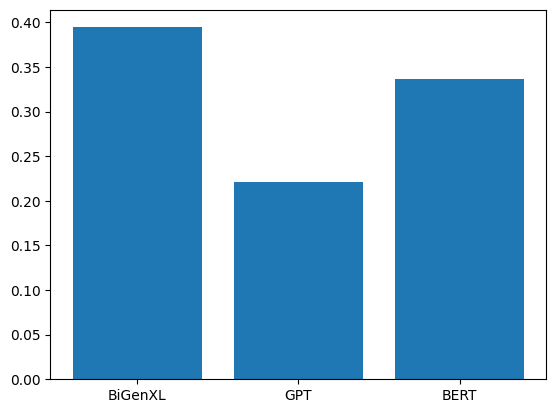

In [ ]:
import matplotlib.pyplot as plt
x=np.array(["BiGenXL","GPT","BERT"])
y=np.array([f1,f3,f2])
plt.bar(x,y)
plt.show()

In [ ]:
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Specify the path to the runtime folder
runtime_folder_path = '/content/templates'  # Replace with the actual path

# 3. Specify the destination path in Drive
drive_destination_path = '/content/drive/MyDrive/'  # Replace with your desired path

# 4. Ensure the destination folder exists
os.makedirs(drive_destination_path, exist_ok=True)

# 5. Copy the runtime folder to Drive
!cp -r $runtime_folder_path $drive_destination_path

print("Runtime folder uploaded to Drive!")